# Car Price Prediction Assignment
## 1. Problem Definition & Data Collection
**Objective:** Predict the price of used cars based on attributes like mileage, year, engine capacity, and model.
**Dataset:** A collection of used car listings (Toyota, Suzuki, Honda, etc.) filtered for hatchbacks manufactured after 2005.

In [1]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 2. Data Loading & Preprocessing
We load the cleaned dataset which has already undergone:
- Removal of units (km, cc)
- Filtering for domain (Hatchbacks, Year > 2005, Price <= 10M)
- One-Hot Encoding for Fuel Type

In [2]:
# Load Data
file_path = '../data/processed/cleaned_car_data.csv'
try:
    df = pd.read_csv(file_path)
    print(f"✅ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("❌ Error: File not found. Please run 'preprocess.py' first.")

# Overview
df.head()

✅ Loaded dataset with 762 rows and 6 columns.


,mileage,engine_capacity,manufacture_year,model,fuel_type_Petrol,price
0,1200,1200,2010,March,True,6150000
1,110000,1250,2007,March,True,4350000
2,180000,660,2016,Dayz,True,5500000
3,38854,650,2016,Dayz,True,5885000
4,17000,660,2023,Roox Highway Star X,False,8375000


### Feature Engineering
The 'model' column is categorical text (e.g., 'Vitz', 'Swift'). 
Random Forest requires numerical input, so we use **One-Hot Encoding**.

In [3]:
# Define Features (X) and Target (y)
X = df.drop(columns=['price'], errors='ignore')
y = df['price']

# One-Hot Encoding for 'model' column
# drop_first=True avoids multicollinearity
X = pd.get_dummies(X, columns=['model'], drop_first=True)

print(f"Feature set shape after encoding: {X.shape}")

Feature set shape after encoding: (762, 46)


## 3. Model Training
We use **Random Forest Regressor**.

**Justification:**
- It handles non-linear relationships better than Linear Regression.
- It is robust to outliers and doesn't require feature scaling.
- It provides built-in feature importance.

**Hyperparameters (Pruning):**
- `n_estimators=100`: Builds 100 trees for stability.
- `max_depth=15`: Limits tree depth to prevent **Overfitting**.
- `min_samples_split=5`: Ensures leaves contain enough data points.

In [4]:
# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")

# Initialize Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,          # Pruning parameter
    min_samples_split=5,   # Pruning parameter
    random_state=42
)

# Train
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete.")

Training samples: 609
Testing samples:  153
Training Random Forest model...
Training complete.


## 3.1. Model Persistence
Save the trained model and related artifacts for future use without retraining.

In [5]:
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# 1. Save the trained Random Forest model
model_path = '../models/random_forest_car_price_model.pkl'
joblib.dump(rf_model, model_path)
print(f"✅ Model saved to: {model_path}")

# 2. Save feature names (critical for making predictions later)
feature_names = X_train.columns.tolist()
feature_path = '../models/feature_names.json'
with open(feature_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"✅ Feature names saved to: {feature_path}")

# 3. Save model metadata
metadata = {
    'model_type': 'RandomForestRegressor',
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 5,
    'random_state': 42,
    'training_samples': X_train.shape[0],
    'testing_samples': X_test.shape[0],
    'n_features': X_train.shape[1],
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Model metadata saved to: {metadata_path}")

print("\n" + "="*50)
print("All model artifacts saved successfully!")
print("="*50)

✅ Model saved to: ../models/random_forest_car_price_model.pkl
✅ Feature names saved to: ../models/feature_names.json
✅ Model metadata saved to: ../models/model_metadata.json

All model artifacts saved successfully!


## 4. Evaluation
We evaluate the model using:
- **R² Score:** How well the model explains variance (Accuracy).
- **MAE (Mean Absolute Error):** Average error in Rupees.
- **RMSE (Root Mean Squared Error):** Penalizes large errors more heavily.

------------------------------
Model Performance Results:
✅ Accuracy (R² Score): 0.8938 (89.38%)
❌ Mean Absolute Error: Rs. 285,402.91
❌ RMSE:                Rs. 410,992.74
------------------------------


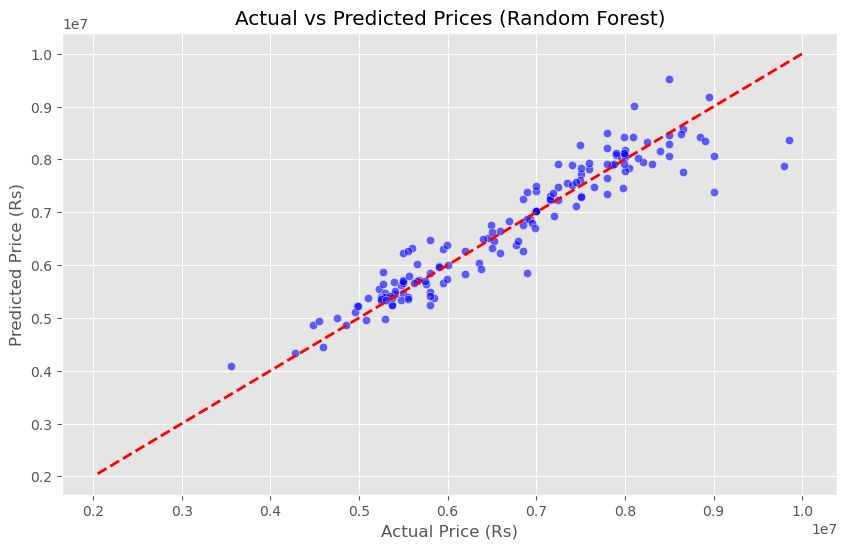

In [6]:
# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("-" * 30)
print(f"Model Performance Results:")
print(f"✅ Accuracy (R² Score): {r2:.4f} ({r2*100:.2f}%)")
print(f"❌ Mean Absolute Error: Rs. {mae:,.2f}")
print(f"❌ RMSE:                Rs. {rmse:,.2f}")
print("-" * 30)

# Visualizing Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Ideal line
plt.xlabel("Actual Price (Rs)")
plt.ylabel("Predicted Price (Rs)")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.show()

## 4.1. Save Evaluation Metrics
Persist model performance metrics for documentation and comparison.

In [7]:
# Save evaluation metrics
metrics = {
    'r2_score': float(r2),
    'mean_absolute_error': float(mae),
    'root_mean_squared_error': float(rmse),
    'r2_percentage': float(r2 * 100),
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_samples': len(y_test)
}

metrics_path = '../models/evaluation_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Evaluation metrics saved to: {metrics_path}")
print(f"\nSaved metrics:")
for key, value in metrics.items():
    if 'error' in key.lower() or 'rmse' in key.lower():
        print(f"  - {key}: Rs. {value:,.2f}")
    elif 'percentage' in key.lower():
        print(f"  - {key}: {value:.2f}%")
    elif 'score' in key.lower():
        print(f"  - {key}: {value:.4f}")
    else:
        print(f"  - {key}: {value}")

✅ Evaluation metrics saved to: ../models/evaluation_metrics.json

Saved metrics:
  - r2_score: 0.8938
  - mean_absolute_error: Rs. 285,402.91
  - root_mean_squared_error: Rs. 410,992.74
  - r2_percentage: 89.38%
  - evaluation_date: 2026-02-19 20:41:56
  - test_samples: 153


## 5. Explainability (XAI) - Requirement 4
We use **SHAP (SHapley Additive exPlanations)** to explain *why* the model predicts specific prices.

- **Summary Plot:** Shows which features are most important globally.
- **Dependence Plot:** Shows how a single feature (e.g., Year) affects price.

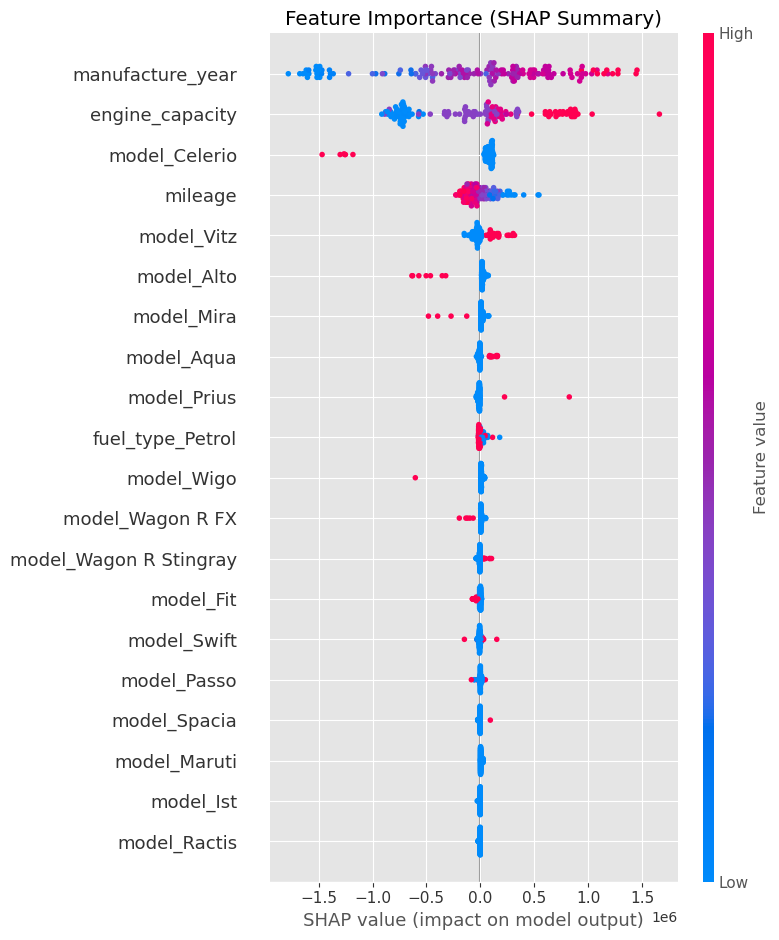

Dependence Plot: Effect of Manufacture Year on Price


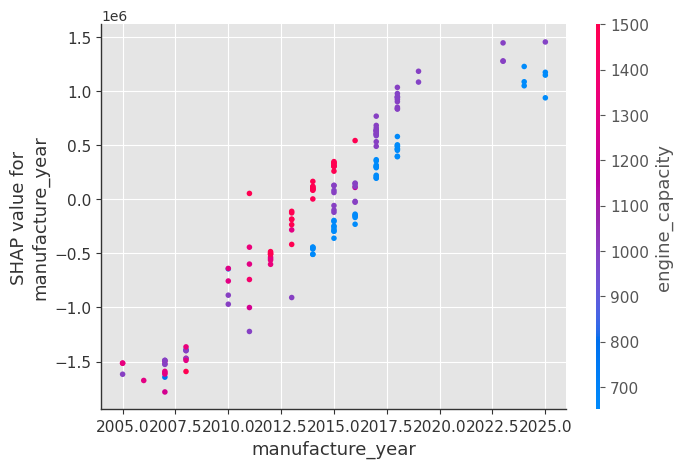

In [9]:
# Initialize JS visualization code
shap.initjs()

# Create TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 1. Summary Plot (Feature Importance)
plt.figure(figsize=(12, 8))
plt.title("Feature Importance (SHAP Summary)")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

# 2. Dependence Plot for 'manufacture_year'
# This shows how the Year affects the price prediction
print("Dependence Plot: Effect of Manufacture Year on Price")
shap.dependence_plot("manufacture_year", shap_values, X_test)

## 6. Using the Saved Model
This section demonstrates how to load the saved model and make predictions.

In [8]:
# Load the saved model
loaded_model = joblib.load('../models/random_forest_car_price_model.pkl')
print("✅ Model loaded successfully!")

# Load feature names
with open('../models/feature_names.json', 'r') as f:
    saved_features = json.load(f)
print(f"✅ Loaded {len(saved_features)} feature names")

# Load metadata
with open('../models/model_metadata.json', 'r') as f:
    saved_metadata = json.load(f)
print(f"✅ Model was trained on: {saved_metadata['trained_date']}")

# Example: Make a prediction using the loaded model
# Take the first 5 samples from test set
sample_data = X_test.head(5)
sample_predictions = loaded_model.predict(sample_data)

print("\n" + "="*60)
print("Sample Predictions using Loaded Model:")
print("="*60)
for i, (idx, row) in enumerate(sample_data.iterrows()):
    actual_price = y_test.loc[idx]
    predicted_price = sample_predictions[i]
    print(f"\nSample {i+1}:")
    print(f"  Actual Price:    Rs. {actual_price:,.0f}")
    print(f"  Predicted Price: Rs. {predicted_price:,.0f}")
    print(f"  Difference:      Rs. {abs(actual_price - predicted_price):,.0f}")

✅ Model loaded successfully!
✅ Loaded 46 feature names
✅ Model was trained on: 2026-02-19 20:33:56

Sample Predictions using Loaded Model:

Sample 1:
  Actual Price:    Rs. 4,475,000
  Predicted Price: Rs. 4,867,969
  Difference:      Rs. 392,969

Sample 2:
  Actual Price:    Rs. 6,000,000
  Predicted Price: Rs. 5,996,586
  Difference:      Rs. 3,414

Sample 3:
  Actual Price:    Rs. 6,850,000
  Predicted Price: Rs. 7,256,560
  Difference:      Rs. 406,560

Sample 4:
  Actual Price:    Rs. 9,850,000
  Predicted Price: Rs. 8,372,055
  Difference:      Rs. 1,477,945

Sample 5:
  Actual Price:    Rs. 8,850,000
  Predicted Price: Rs. 8,420,242
  Difference:      Rs. 429,758
